# Installation

## Install in local Python environment (where jupyter notebook is started):

```
python -m pip install ipywidgets pandas
```

## Install in Slicer Python environment (by running the cell below):

In [ ]:
# There are no official pyzmq wheels for Python-3.6 for Windows, so we have to install manually
import os
if os.name=='nt':
    pip_install("https://files.pythonhosted.org/packages/94/e1/13059383d21444caa16306b48c8bf7a62331ca361d553d2119696ea67119/pyzmq-19.0.0-cp36-cp36m-win_amd64.whl")

pip_install("ipywidgets pandas")

# Interactive volume rendering
The entire view layout or selected widgets can be displayed in a notebook cell. Views can be shown using interactive widgets (slice scrolling, view rotation).
Rendering happens server-side, in Slicer, which can run on the cloud, on a container. Source data does not have to be sent to the user's computer.

IntProgress(value=0)

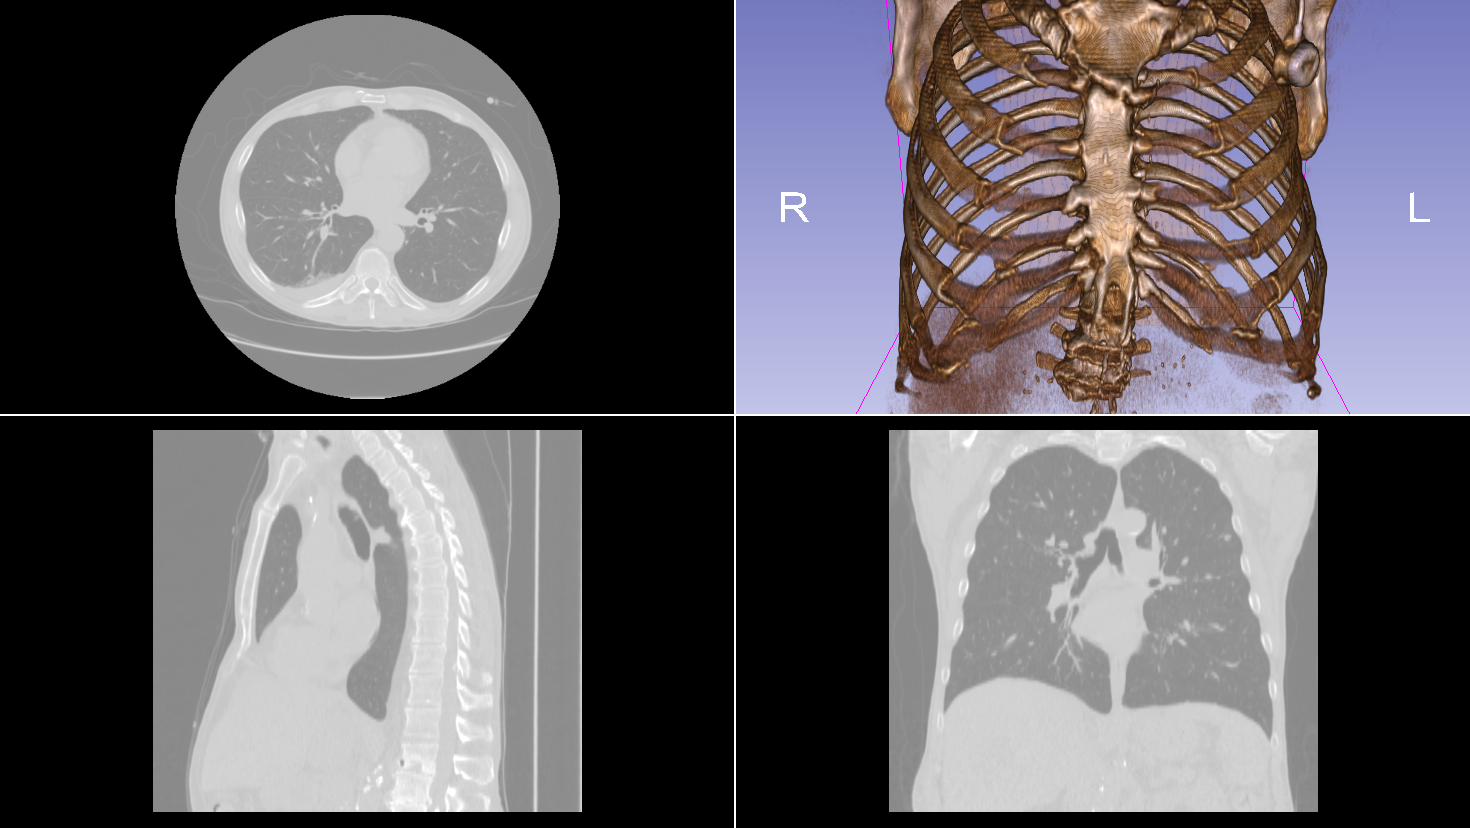

In [3]:
# Get a volume
slicer.mrmlScene.Clear()
volume = slicer.nb.downloadFromURL(
  'https://github.com/Slicer/SlicerTestingData/releases/download/SHA256/4507b664690840abb6cb9af2d919377ffc4ef75b167cb6fd0f747befdb12e38e',
  'CTChest.nrrd', "CT")[0]

# Enable 3D volume rendering
slicer.nb.showVolumeRendering(volume)

slicer.nb.displayViews("FourUp")
#slicer.nb.displayViews("Conventional")
# slicer.nb.displaySliceView('Red')
# slicer.nb.display3DView()

In [1]:
# Interactive 3D view
from ipywidgets import interact

@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-180.0,180.0,5))
def update(roll=0, pitch=0, yaw=0):
    return slicer.nb.display3DView(0, orientation=[roll, pitch, yaw])

interactive(children=(FloatSlider(value=0.0, description='roll', max=90.0, min=-90.0, step=5.0), FloatSlider(v…

# Interactive segmentation visualization

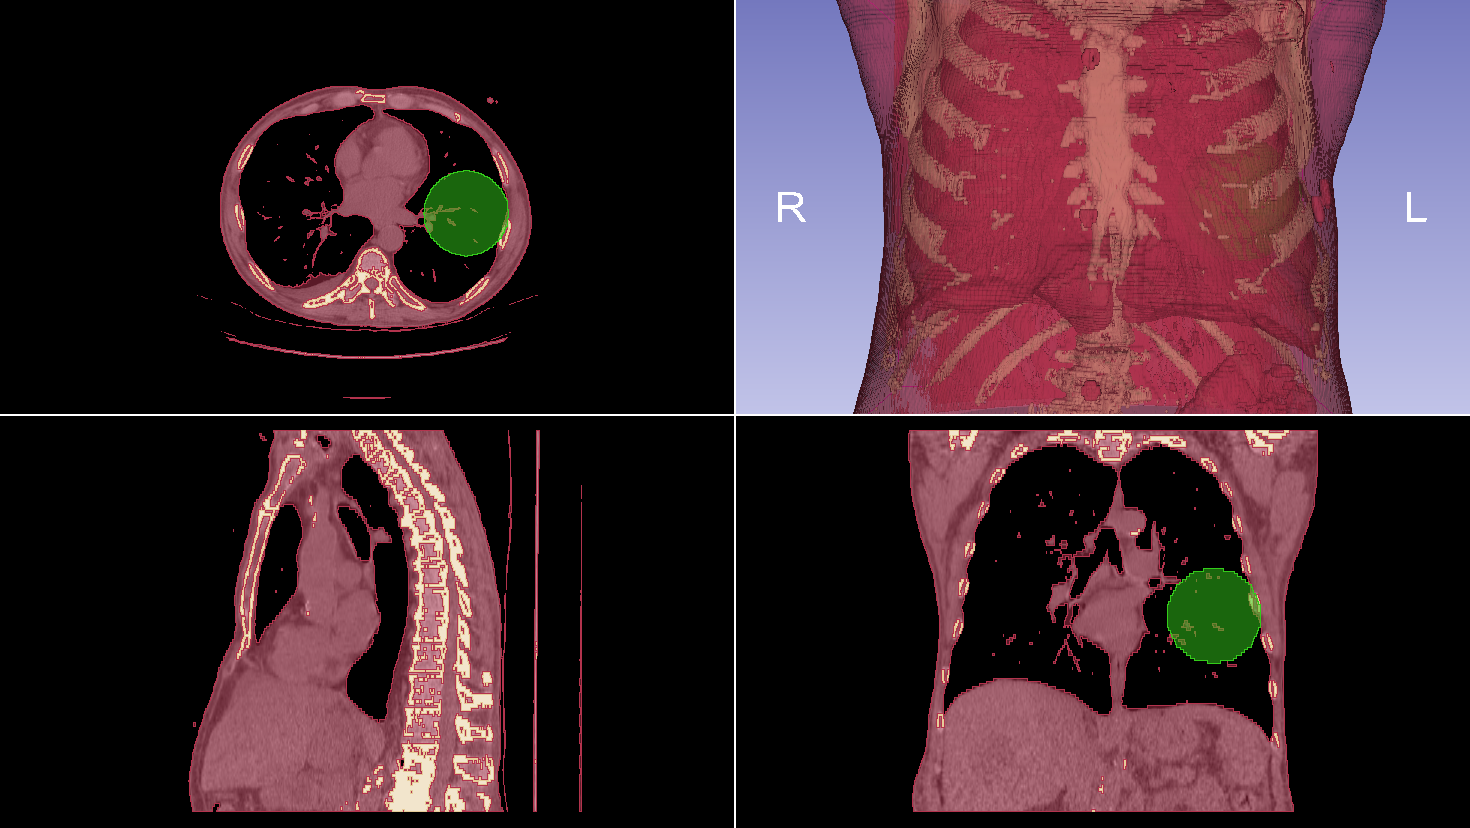

In [5]:
# Create segmentation using thresholding
slicer.util.selectModule("SegmentEditor")
segmentEditorWidget = slicer.modules.segmenteditor.widgetRepresentation().self().editor
segmentEditorNode = segmentEditorWidget.mrmlSegmentEditorNode()

segmentationNode=slicer.mrmlScene.GetFirstNodeByClass("vtkMRMLSegmentationNode")
if not segmentationNode:
    segmentationNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLSegmentationNode")
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volume)
segmentationNode.GetSegmentation().RemoveAllSegments()

# Add bone segment
segmentID = segmentationNode.GetSegmentation().AddEmptySegment("bone")
segmentationNode.GetSegmentation().GetSegment(segmentID).SetColor(0.9, 0.8, 0.6)
segmentEditorNode.SetSelectedSegmentID(segmentID)
segmentEditorWidget.setActiveEffectByName("Threshold")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MinimumThreshold", 220)
effect.setParameter("MaximumThreshold", 2000)
effect.self().onApply()

# Add body segment
segmentID = segmentationNode.GetSegmentation().AddEmptySegment("body")
segmentEditorNode.SetSelectedSegmentID(segmentID)
segmentationNode.GetSegmentation().GetSegment(segmentID).SetColor(0.7, 0.2, 0.3)
segmentEditorWidget.setActiveEffectByName("Threshold")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MinimumThreshold", -500)
effect.setParameter("MaximumThreshold", 220)
effect.self().onApply()

# Add a sphere-shaped segment
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(-100, -30, -170)
sphereSource.SetRadius(45)
sphereSource.SetThetaResolution(20)
sphereSource.Update()
segmentationNode.AddSegmentFromClosedSurfaceRepresentation(sphereSource.GetOutput(), "sphere", [0.2,0.8,0.1])

# Show results
slicer.modules.volumerendering.logic().GetFirstVolumeRenderingDisplayNode(volume).VisibilityOff() # hide volume rendering
segmentationNode.GetSegmentation().SetConversionParameter('Smoothing factor','0.0') # disable 3D smoothing
segmentationNode.CreateClosedSurfaceRepresentation() # show segmentation in 3D
segmentationNode.GetDisplayNode().SetOpacity3D(0.5)
volume.GetDisplayNode().AutoWindowLevelOff()
volume.GetDisplayNode().SetWindowLevel(420,30)
slicer.nb.displayViews()

In [6]:
# Interactive slice view
from ipywidgets import interact
@interact(position=(0,100))
def update(position=50):
    return slicer.nb.displaySliceView('Red', positionPercent=position)

interactive(children=(IntSlider(value=50, description='position'), Output()), _dom_classes=('widget-interact',…

# Quantify segmentation and show results in table

In [7]:
# Compute segment volumes
resultsTableNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLTableNode')
import SegmentStatistics
segStatLogic = SegmentStatistics.SegmentStatisticsLogic()
segStatLogic.getParameterNode().SetParameter("Segmentation", segmentationNode.GetID())
segStatLogic.getParameterNode().SetParameter("ScalarVolume", volume.GetID())
segStatLogic.getParameterNode().SetParameter("LabelmapSegmentStatisticsPlugin.enabled","False")
segStatLogic.getParameterNode().SetParameter("ScalarVolumeSegmentStatisticsPlugin.voxel_count.enabled","False")
segStatLogic.getParameterNode().SetParameter("ScalarVolumeSegmentStatisticsPlugin.volume_mm3.enabled","False")
segStatLogic.computeStatistics()
segStatLogic.exportToTable(resultsTableNode)
resultsTableNode

,Segment,Volume [cm3] (1),Minimum,Maximum,Mean,Median,Standard Deviation,Surface area [mm2],Volume [mm3],Volume [cm3] (2)
0,bone,810.203214,221.0,2000.0,404.718310,350.0,180.311880,7.333770e+05,7.893223e+05,789.322271
1,body,16060.581251,-500.0,220.0,-6.456390,17.0,104.117558,2.284824e+06,1.604587e+07,16045.869356
2,sphere,356.806618,-1017.0,1058.0,-787.820649,-861.0,222.253065,2.883628e+04,3.566709e+05,356.670883


# Download computation results

In [8]:
# Export segmentation to a labelmap and make it available for download
labelmapVolumeNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLLabelMapVolumeNode')
slicer.modules.segmentations.logic().ExportVisibleSegmentsToLabelmapNode(segmentationNode, labelmapVolumeNode, volume)
outputLabelmapFile = "outputs/BodyComposition-label.nrrd"
slicer.util.saveNode(labelmapVolumeNode, slicer.nb.localPath(outputLabelmapFile))
slicer.mrmlScene.RemoveNode(labelmapVolumeNode)

from IPython.display import FileLink
FileLink(outputLabelmapFile)

C:\D\SlicerNotebooks\outputs\BodyComposition-label.nrrd

# Display of markups

In [9]:
import numpy as np
markupPoints = np.array([
       [ 136.09512665,   -5.77634208, -255.175     ],
       [ 108.95226101,   48.50938919, -255.175     ],
       [  31.80937972,   82.79511421, -255.175     ],
       [ -19.6192078 ,  107.0808361 , -255.175     ],
       [ -76.76208283,   87.08082984, -255.175     ],
       [ -59.61922032,   21.36652355, -255.175     ],
       [ -23.90492343,    7.0808048 , -255.175     ],
       [  34.66652348,  -38.63349523, -255.175     ],
       [  66.09510474,  -85.77636712, -255.175     ],
       [ 111.80940476,  -90.06208275, -255.175     ],
       [ 141.80941415,  -51.49064211, -255.175     ]])
closedCurve = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLMarkupsClosedCurveNode")
slicer.util.updateMarkupsControlPointsFromArray(closedCurve, markupPoints)

closedCurve

,label,position.R,position.A,position.S,selected,visible,description
0,MarkupsClosedCurve-1,136.095127,-5.776342,-255.175,True,True,
1,MarkupsClosedCurve-2,108.952261,48.509389,-255.175,True,True,
2,MarkupsClosedCurve-3,31.809380,82.795114,-255.175,True,True,
3,MarkupsClosedCurve-4,-19.619208,107.080836,-255.175,True,True,
4,MarkupsClosedCurve-5,-76.762083,87.080830,-255.175,True,True,
5,MarkupsClosedCurve-6,-59.619220,21.366524,-255.175,True,True,
6,MarkupsClosedCurve-7,-23.904923,7.080805,-255.175,True,True,
7,MarkupsClosedCurve-8,34.666523,-38.633495,-255.175,True,True,
8,MarkupsClosedCurve-9,66.095105,-85.776367,-255.175,True,True,
9,MarkupsClosedCurve-10,111.809405,-90.062083,-255.175,True,True,


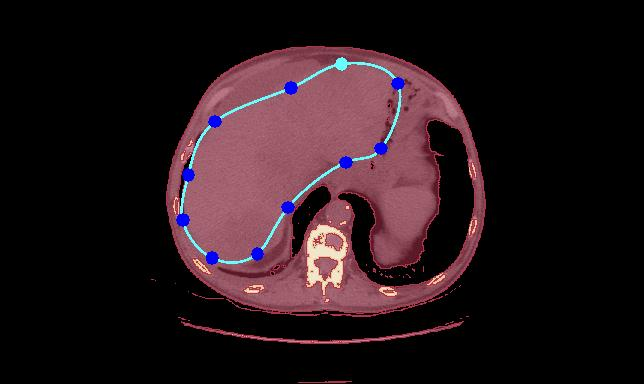

In [10]:
closedCurve.SetNthControlPointSelected(3, False)
closedCurve.GetDisplayNode().SetSelectedColor(0,0,1)
closedCurve.GetDisplayNode().SetGlyphScale(5)
closedCurve.GetDisplayNode().UseGlyphScaleOn()
slicer.modules.markups.logic().JumpSlicesToNthPointInMarkup(closedCurve.GetID(), 0)
slicer.nb.displaySliceView('Red')

# Processing using CLI module

Creating mesh from volume...


IntProgress(value=0)

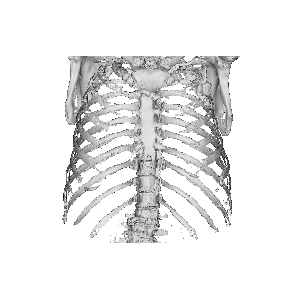

In [11]:
# Interactive CLI module execution (with progress reporting)

parameters = {}
parameters["InputVolume"] = volume.GetID()
parameters["Threshold"] = 220
outModel = slicer.vtkMRMLModelNode()
slicer.mrmlScene.AddNode( outModel )
parameters["OutputGeometry"] = outModel.GetID()
grayMaker = slicer.modules.grayscalemodelmaker
print("Creating mesh from volume...")
slicer.nb.cliRunSync(grayMaker, None, parameters)

slicer.nb.displayModel(outModel, orientation=[0,-90,0])

In [12]:
# Set CLI module parameters using interactive widget

from ipywidgets import interact_manual
@interact_manual(threshold=(-500.0,1200,5))
def h(threshold=-100):
    parameters["Threshold"] = threshold
    slicer.nb.cliRunSync(grayMaker, None, parameters)
    return slicer.nb.displayModel(outModel, orientation=[0,-90,0])

interactive(children=(FloatSlider(value=-100.0, description='threshold', max=1200.0, min=-500.0, step=5.0), Bu…

In [13]:
# Download created model

outputFile = "segmented-model.stl"
slicer.util.saveNode(outModel, slicer.nb.localPath(outputFile))

from IPython.display import FileLink
FileLink(outputFile)

C:\D\SlicerNotebooks\segmented-model.stl

# Model display
An experimental approach is used for displaying model nodes. They are rendered outside the views in the layout, therefore only this node is visible.

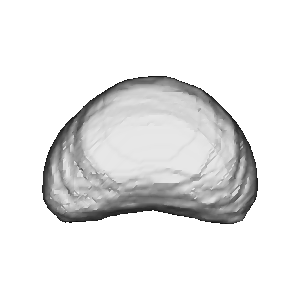

In [14]:
# Simple static display

modelNode=slicer.modules.models.logic().AddModel(slicer.nb.localPath("Data\ProstateMeanShape.stl"))
modelNode

In [15]:
# Interactive view rotation

from ipywidgets import interact
@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-90.0,90.0,5))
def update(roll=0, pitch=0, yaw=0):
    return slicer.nb.displayModel(modelNode, orientation=[roll, pitch, yaw], imageSize=[200,200])

interactive(children=(FloatSlider(value=0.0, description='roll', max=90.0, min=-90.0, step=5.0), FloatSlider(v…

# Other utility/debugging functions

In [ ]:
slicer.nb.notebookPath()

In [ ]:
__kernel_debug_enable()

In [ ]:
__kernel_debug_disable()

In [ ]:
# File upload - currently not working see https://github.com/jupyter-xeus/xeus-python/issues/272
uploader=slicer.nb.FileUploadWidget()
uploader.widget

In [ ]:
# This cell will work after file upload (above cell) is fixed
model=slicer.modules.models.logic().AddModel(uploader.path)
model